In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean

In [3]:
df = pd.read_csv('./data/final_annotations_duplicatesTagged_modTBDs - final_annotations_duplicatesTagged.csv')

In [4]:
df.columns

Index(['sentence', 'sentiment', 'impact', 'sentiments', 'impacts', 'batch',
       'film_title', 'sentences_nopunc', 'duplicated'],
      dtype='object')

In [5]:
df.drop(['sentence', 'sentiments','impacts', 'film_title', 'batch', 'sentiment'], axis = 1, inplace = True) ## drop columns that are not needed
df = df[df['duplicated'] != True] # remove duplicates 
df = df[df['impact'] != 'TBD'] # remove TBDs
df.drop(['duplicated'], axis = 1, inplace = True) # drop duplicated column

In [6]:
df.head()

,impact,sentences_nopunc
0,Engagement with Film,a few spots were boring
1,Engagement with Film,we landed probes on mars and orbited celestial...
2,Engagement with Film,very dry and unimaginative
3,Engagement with Film,it seemed a bit repetitive
4,Engagement with Film,i didnt watch it past 4 minutes


In [7]:
df.value_counts('impact')

impact
Engagement with Film           718
Not applicable                 176
Shift in Knowledge             138
Interest with Science Topic     86
Impersonal Report               41
dtype: int64

## impact analysis while using SMOTE for oversampling the minority class and weight balancing both for training and testing data


In [8]:
X = df['sentences_nopunc']
y = df['impact']

In [9]:
y = df['impact'].map({'Engagement with Film': 0, 'Not applicable': 1, 'Shift in Knowledge': 2, 'Interest with Science Topic': 3, 'Impersonal Report': 4})

In [10]:
y.value_counts()

0    718
1    176
2    138
3     86
4     41
Name: impact, dtype: int64

In [11]:
stop_words = set(stopwords.words('english'))

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    return [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]

vectorizer = CountVectorizer(stop_words = stop_words, tokenizer = lemmatize_text)
X = vectorizer.fit_transform(df["sentences_nopunc"])

In [12]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

## weight the classes
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y                                                    
                                    )

class_weights = dict(zip(np.unique(y), class_weights))
## split the data into training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## training XGBoost model classifier

In [13]:
## create a model

xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = xgbModel.predict(X_train)
y_pred_test = xgbModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.9658774373259053
Accuracy on testing data:  0.8635097493036211
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       162
           1       0.70      0.94      0.80       132
           2       0.93      0.89      0.91       138
           3       0.98      0.89      0.93       140
           4       0.99      0.95      0.97       146

    accuracy                           0.86       718
   macro avg       0.87      0.87      0.87       718
weighted avg       0.87      0.86      0.86       718



## Confusion Matrix for the model Train and Test datasets

<AxesSubplot: >

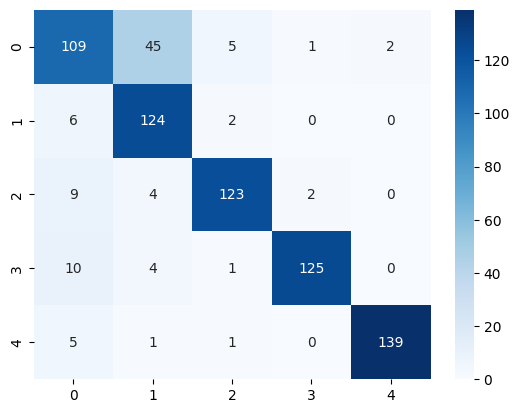

In [14]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<AxesSubplot: >

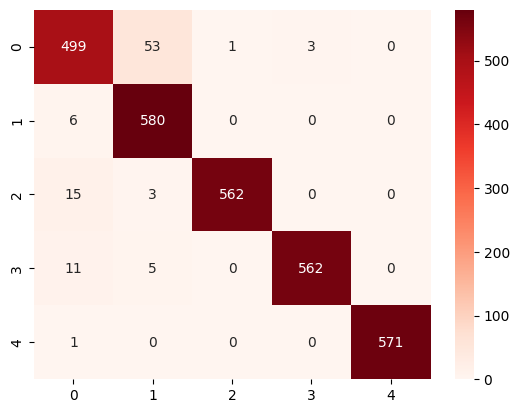

In [15]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')

## Training Random Forest Classifier model

In [16]:
rfModel = RandomForestClassifier()
rfModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = rfModel.predict(X_train)
y_pred_test = rfModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.645891364902507
Accuracy on testing data:  0.46657381615598886
              precision    recall  f1-score   support

           0       0.86      0.49      0.63       162
           1       0.31      0.89      0.46       132
           2       0.49      0.33      0.40       138
           3       0.62      0.20      0.30       140
           4       0.61      0.44      0.51       146

    accuracy                           0.47       718
   macro avg       0.58      0.47      0.46       718
weighted avg       0.59      0.47      0.46       718



## Confusion matrix for trai and test data

<AxesSubplot: >

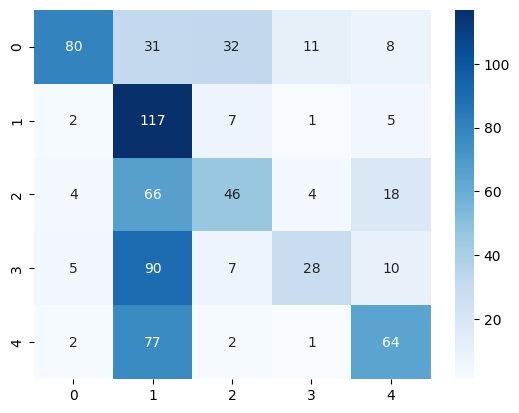

In [17]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<AxesSubplot: >

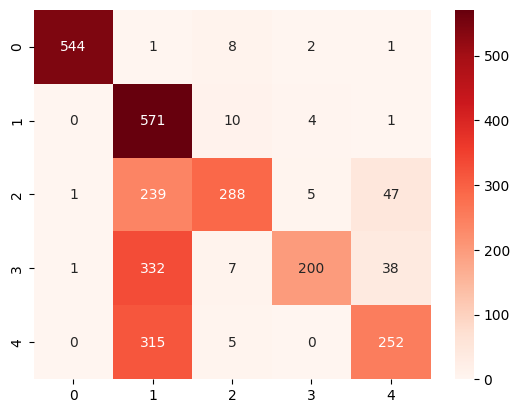

In [18]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Reds')

## Training ADABoost Classifier model

In [19]:
from sklearn.ensemble import AdaBoostClassifier

adaModel = AdaBoostClassifier()
adaModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = adaModel.predict(X_train)
y_pred_test = adaModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.4418523676880223
Accuracy on testing data:  0.4025069637883008
              precision    recall  f1-score   support

           0       0.72      0.52      0.60       162
           1       0.26      0.93      0.40       132
           2       0.60      0.25      0.35       138
           3       0.88      0.10      0.18       140
           4       0.68      0.23      0.35       146

    accuracy                           0.40       718
   macro avg       0.63      0.41      0.38       718
weighted avg       0.63      0.40      0.38       718



## confusion matrix for train and test data

<AxesSubplot: >

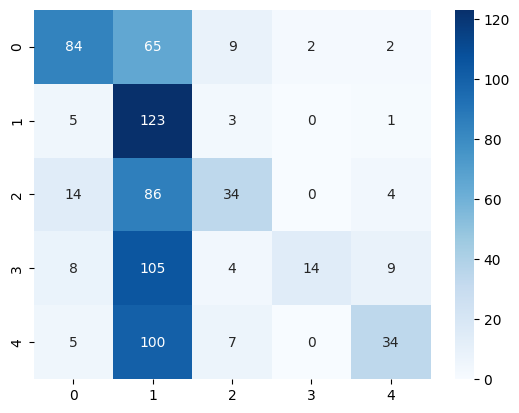

In [20]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

<AxesSubplot: >

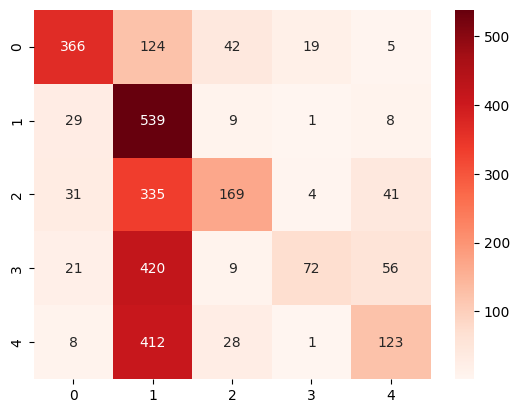

In [21]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Reds')

# sentiment analysis while using class weights and SMOTE only for the testing data

In [22]:
X = df['sentences_nopunc']
y = df['impact']

y = df['impact'].map({'Engagement with Film': 0, 'Not applicable': 1, 'Shift in Knowledge': 2, 'Interest with Science Topic': 3, 'Impersonal Report': 4})

In [23]:
X = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test = sm.fit_resample(X_test, y_test) 

## Training XGBoost Classifier model

In [24]:
xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_test = xgbModel.predict(X_test)
y_pred_train = xgbModel.predict(X_train)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.8673139158576052
Accuracy on testing data:  0.31390728476821195
              precision    recall  f1-score   support

           0       0.28      0.89      0.42       151
           1       0.43      0.07      0.11       151
           2       0.47      0.44      0.46       151
           3       0.30      0.17      0.22       151
           4       0.00      0.00      0.00       151

    accuracy                           0.31       755
   macro avg       0.30      0.31      0.24       755
weighted avg       0.30      0.31      0.24       755



## Confusion matrix for train and test data

<AxesSubplot: >

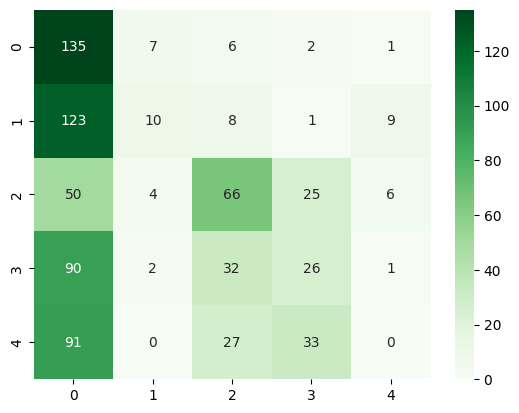

In [25]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

<AxesSubplot: >

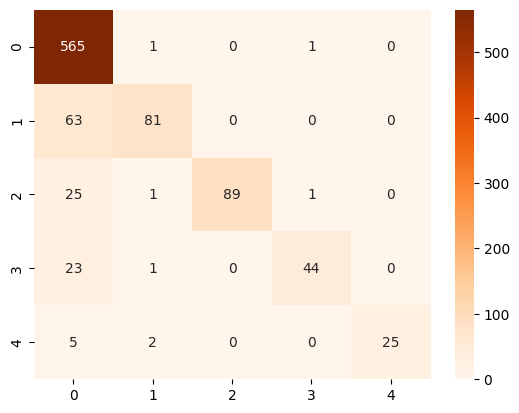

In [26]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Oranges')

## Training Random Forest Classifier

In [27]:
rfModel = RandomForestClassifier()
rfModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = rfModel.predict(X_train)
y_pred_test = rfModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy on training data:  0.9989212513484358
Accuracy on testing data:  0.3337748344370861
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       151
           1       0.24      0.90      0.38       151
           2       0.40      0.03      0.05       151
           3       0.33      0.01      0.01       151
           4       0.00      0.00      0.00       151

    accuracy                           0.33       755
   macro avg       0.33      0.33      0.23       755
weighted avg       0.33      0.33      0.23       755



## Confusion matrix for train and test data

<AxesSubplot: >

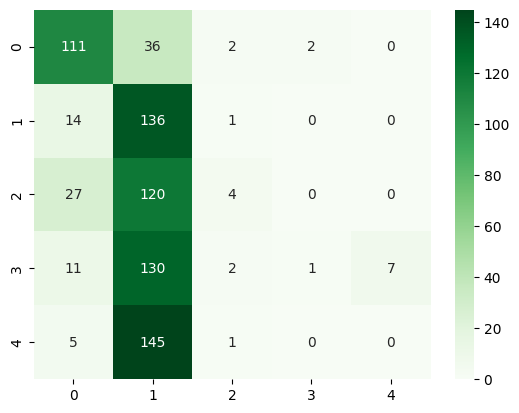

In [28]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

<AxesSubplot: >

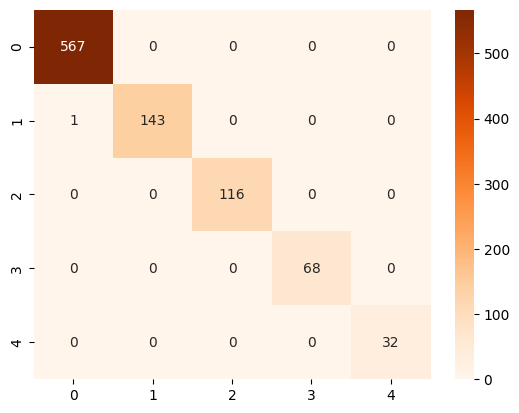

In [29]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Oranges')

## Training ADABoost Classifier model

In [30]:
adaModel = AdaBoostClassifier()
adaModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))

y_pred_train = adaModel.predict(X_train)
y_pred_test = adaModel.predict(X_test)

print("Accuracy on training data: ", accuracy_score(y_train, y_pred_train))
print("Accuracy on testing data: ", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, zero_division=0))

Accuracy on training data:  0.6094929881337648
Accuracy on testing data:  0.1947019867549669
              precision    recall  f1-score   support

           0       0.19      0.93      0.32       151
           1       0.00      0.00      0.00       151
           2       0.22      0.03      0.05       151
           3       0.22      0.01      0.03       151
           4       0.33      0.01      0.01       151

    accuracy                           0.19       755
   macro avg       0.19      0.19      0.08       755
weighted avg       0.19      0.19      0.08       755



## Confusion Matrix for train and test data

<AxesSubplot: >

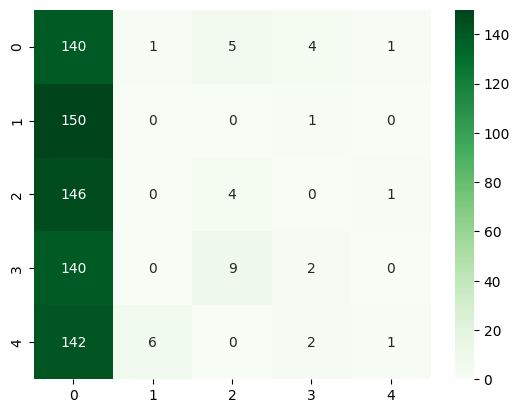

In [31]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

<AxesSubplot: >

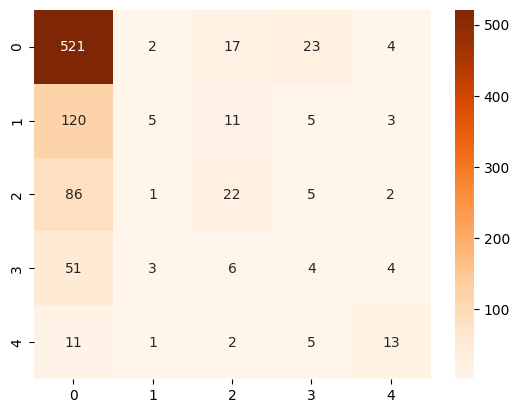

In [32]:
cm = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Oranges')

## Using Stratified Cross Validation for XGBoost

In [33]:
X = df['sentences_nopunc']
y = df['impact']

y = y.map({'Engagement with Film': 0, 'Not applicable': 1, 'Shift in Knowledge': 2, 'Interest with Science Topic': 3, 'Impersonal Report': 4})

X = vectorizer.fit_transform(X)

X, y = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
xgbModel = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
accuracy_list_train = []
accuracy_list_test = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgbModel.fit(X_train, y_train, sample_weight = y_train.map(class_weights))
    y_pred_train = xgbModel.predict(X_train)
    y_pred_test = xgbModel.predict(X_test)
    accuracy_list_test.append(accuracy_score(y_test, y_pred_test))
    accuracy_list_train.append(accuracy_score(y_train, y_pred_train))


print("max Accuracy on testing data: ", max(accuracy_list_test))
print("mean Accuracy on testing data: ", mean(accuracy_list_test))
print("max Accuracy on training data: ", max(accuracy_list_train))
print("mean Accuracy on training data: ", mean(accuracy_list_train))

max Accuracy on testing data:  0.9108635097493036
mean Accuracy on testing data:  0.8844011142061281
max Accuracy on training data:  0.9668833178582482
mean Accuracy on training data:  0.9627359950479728
